In [1]:
"""Notebook following Desponds et al's autocorrelation inference procedure on their data as a positive control"""

"Notebook following Desponds et al's autocorrelation inference procedure on their data as a positive control"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gfp_signal
from telegraph import exponential

In [3]:
from astropy.table import Table

In [4]:
import csv
import os

In [5]:
def findMiddleIndex(input_list):
    middle = float(len(input_list))/2
    if middle % 2 != 0:
        return int(middle - .5)
    else:
        return (int(middle))

In [929]:
findMiddleIndex(t['spot_1'])

34

In [927]:
# take in anterior cell cycle 13 data ... Pon should be about 0.45
t = Table.read('desponds_data/embryo3-anterior-nc13.csv')

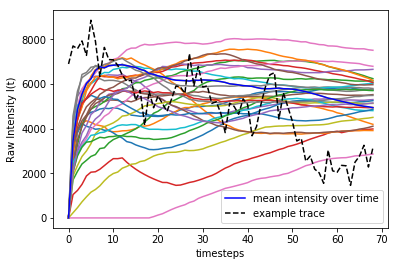

In [1017]:
# take a look at the average intensities over time to define a good "steady-state" window
for name in t.colnames:
    N = 0
    mean = []
    for j in range(len(t[name])):
        N+=1
        mean.append(np.sum(t[name][:j]) / N)
   
    plt.plot(mean)
    
plt.plot(mean, color='blue', label = "mean intensity over time")
plt.plot(t[name], '--', color='k', label='example trace')
plt.xlabel('timesteps')
plt.ylabel('Raw Intensity I(t)')
plt.legend()
    #plt.plot(t[name])

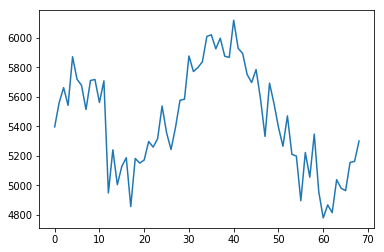

In [1183]:
# plot mean intensity over time
traces=[]
for name in t.colnames:
    traces.append(t[name])

plt.plot(np.mean(traces, axis=0))

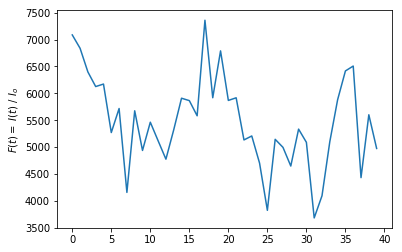

In [1184]:
# compute autocorrelation with long time traces
autolist = []
tracelist = []
max_intens = []

steadystate_start_indx = 25
stop_indx = 50

for j in t.colnames:
# calibrate fluorescence signal: F(t) = I(t) / Io
    max_intens.append(np.max(t[j][steadystate_indx:stop_indx])) # get maximum fluorescence from each trace in given region
        
        # DO WE STILL COUNT ZERO SIGNAL CELLS????  --> yes, in fact, since they contribute to the average gene expression
        # for a given region.
    
I_o = np.mean(np.asarray(max_intens))   # mean of the maxima of all traces in set
#print('Io = ', I_o)

for name in t.colnames:
    trace = t[name][steadystate_indx:stop_indx]
    
    colsum = np.sum(trace)    
    if (colsum == 0):                                      # don't plot the zero signal traces
        auto_norm = np.ones(len(trace)) * np.nan         # set zero signal cells to nan to be ignored
        #corrected_trace = np.ones(len(t[name])) * np.nan
        
    else: 
        # calibrate fluorescence signal: F(t) = I(t) / Io        
        calibrated_trace = trace / I_o   
        
        # subtract out mean signal of each trace to prevent nucleus-nucleus variability
        corrected_trace = calibrated_trace - np.nanmean(calibrated_trace)
        
        auto = np.correlate(corrected_trace, corrected_trace, 'full')
        auto = auto[np.argmax(auto):]     # take half of the autocorrelation function
        
        # finally, normalize        
        auto_norm = auto / auto[0]
        
    autolist.append(auto_norm)
    tracelist.append(calibrated_trace)
    
plt.plot(trace)
    
plt.ylabel(r'$F(t) =$ $I(t)$ / $I_o$')
plt.show()

In [1185]:
autolist;

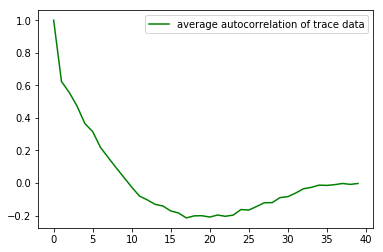

In [1186]:
autoarr = np.asarray(autolist)

autoav = np.nanmean(autoarr, axis=0)
autocov = np.nanvar(autoarr, axis=0)
plt.plot(autoav, color = 'g', label = "average autocorrelation of trace data")
plt.legend(loc='best')
plt.show()

In [1187]:
# STEP TWO: Fit for value of Pon

In [1188]:
# load in Desponds et al's loop function
import scipy.io as spio

loopFn = spio.loadmat('standalone/therightL.mat')

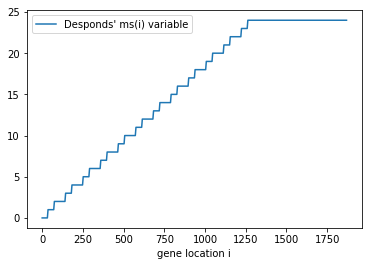

In [1189]:
"""Parameters for Li model
ms: variable describing the number of binding sites on nascent mRNA
    ms[i] is the exact number of binding sites available when polII is 
    at the exact location i along the gene
Li: the number of binding sites on nascent mRNA given a BINNED position of polII i along gene"""
obs_time = 6  # seconds
tPol=6;       # RNAP loading time, corresponds to 1 polII every observation
ke=25;        # Elongation rate
sizePol = tPol * ke
variable = loopFn['ms']
ms = variable[0] 

plt.plot(ms, label = 'Desponds\' ms(i) variable')
plt.xlabel('gene location i')
plt.legend(loc='best')

In [1190]:
"""Now, compute the binned loop Li function"""
Li_fn = []
for i in range(len(ms)//sizePol):    
    Li_fn.append(np.sum(ms[(sizePol*(i-1)+1) : (sizePol*i)]) / sizePol)
    
#for i in range(len(loopfn)//sizePol):
if (i < len(loopfn) // sizePol):
    #print(i)
    Li_fn[i] = np.sum(loopfn[(sizePol*(i)+1):-1]) / sizePol

In [1191]:
np.sum(Li_fn) / 150

1.1357777777777778

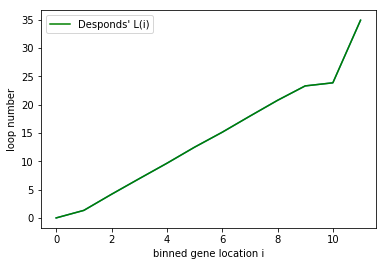

In [1192]:
plt.plot(np.asarray(Li_fn))
plt.plot(Li_fn, label = 'Desponds\' L(i)', color='g')
plt.xlabel('binned gene location i')
plt.ylabel('loop number')
plt.legend(loc='best')

In [1193]:
np.sum(Li_fn) / 150

1.1357777777777778

In [1194]:
# define our average fluorescence function according to Desponds et al's analytic model such that we can fit for p_on
# P_on = <Fluorescence> / sum(loop function)
def avg_flr_fn(average_fluorescence, p_on):
    
    
    # load in Desponds et al's loop function
    import scipy.io as spio
    loopFn = spio.loadmat('standalone/therightL.mat')
    
    ms = loopFn['ms']
    ms = ms[0] # stupid matLab puts an array inside an array
    
    tPol=6; # RNAP loading time
    ke=25;  # Elongation rate
    sizePol = tPol * ke
    
    Li_fn = []
    for i in range(len(ms)//sizePol):    
        Li_fn.append(np.sum(loopfn[(sizePol*(i-1)+1) : (sizePol*i)]) // sizePol)
    
    #for i in range(len(loopfn)//sizePol):
    if (i < len(ms) // sizePol):
        Li_fn[i] = np.sum(ms[(sizePol*(i)+1):-1]) // sizePol
    
    loop = Li_fn   
    average_fluorescence = np.asarray(average_fluorescence)
    
    return p_on * np.sum(loop) / 150   # divide by the FOOTPRINT of one polII molecule
                                       # This ensures that we are in units of 
                                       # number (loops/(polII bin)) * (1/150 (bp/(polII bin)) ####
                                       # final units: loops / bp

In [1195]:
avg_flr(avg_flors, 33)

5412.0

In [1196]:
np.mean(tracelist[4])

0.5852649974868083

In [1197]:
# compute average fluorescence for each raw simulated trace
avg_flors = []
for i in tracelist:
    avg_flors.append(np.mean(i, axis=0))   # stack in an array
np.asarray(avg_flors);


In [1198]:
avg_flors;

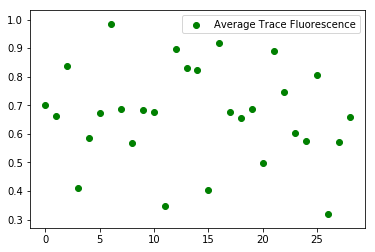

In [1199]:
# give us an easy range to fit over
x = np.arange(len(avg_flors))
plt.scatter(x, avg_flors, color='g', label='Average Trace Fluorescence')
plt.legend(loc='best')

In [1200]:
# do a multiple linear regression fitting for the constant parameter, Pon.
from scipy.optimize import curve_fit
popt_pon,_ = curve_fit(avg_flr_fn, x, ydata=avg_flors)   # return Pon
print("Average fitted P_on for trace package = " + str(popt_pon[0]))

Average fitted P_on for trace package = 0.6110599096937565


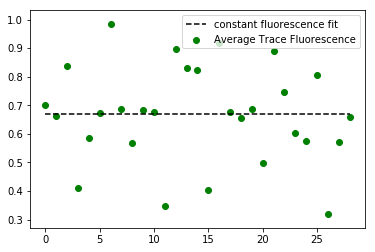

In [1201]:
plt.scatter(x, avg_flors, color='g', label='Average Trace Fluorescence')
plt.plot(x, np.ones(len(x)) * avg_flr_fn(avg_flors, popt_pon),  '--', color='k', label='constant fluorescence fit')

plt.legend(loc ='best')
plt.show()

In [1202]:
# Do a quick bootstrap on the fluorescence averages to get an estimate range for the Pon parameter
x = np.arange(len(avg_flors))
ntrials = 1000                 # number of times we're going to run a fit

n_flor_avgs = len(avg_flors)    # size of our original dataset, our array of <F(t)> values

pon_list = []


sample_indx = np.arange(n_flor_avgs)   # index of our original dataset

# sample randomly with replacement from our set of <F(t)> values 

for i in range(ntrials):
    random_indx = np.random.choice(sample_indx, size=n_flor_avgs, replace=True)
    
    #print(len(random_indx))
    sample_set = np.asarray(avg_flors)[random_indx]    # select from our original dataset
    
    # now re-fit our data with a constant fit for the parameter Pon
    p_on,_ = curve_fit(avg_flr_fn, x, ydata=sample_set)
    
    pon_list.append(p_on)

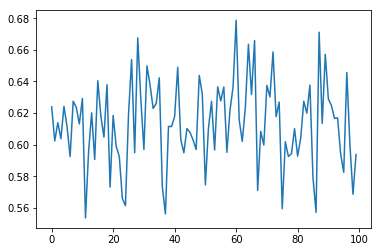

In [1203]:
plt.plot(pon_list[::10])

In [1204]:
from IPython import display
pon_array = np.asarray(pon_list) #* 100
low,med,hi = np.percentile(pon_array, [16, 50, 84], axis=0)
upper, lower = hi-med, med-low

disp_str1 = ""
for i,name in enumerate(['P_{on}']):
        fmt_str = '{name}={val:.4f}^{{+{plus:.4f}}}_{{-{minus:.4f}}}'
        disp_str1 += fmt_str.format(name=name, val=med[i], plus=upper[i], minus=lower[i])
        disp_str1 += r'\quad '

disp_str1 = "${}$".format(disp_str1)
display.Latex(data=disp_str1)


<IPython.core.display.Latex object>